# Analyze Results from Polymorph Test
Given the length of the polymorph test, I have separated the code that runs the test from the code that analyzes the results. This way, you need not re-run the test to re-analyze the results.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm_notebook as tqdm
from scipy.stats import kendalltau
from sklearn import metrics
import numpy as np
import pandas as pd

In [2]:
fig_width = 3.375
fig_height = fig_width * 0.85 # One of the figures is square
fontsize = 12

## Load in the Data
Read in the data from CSV

In [3]:
%%time
data = pd.read_csv('qh-cv-data.csv')

Wall time: 6.11 s


## Analyze the Results
Determine how well the ranking performance worked. We will do this two different ways:

1. Measure the [Kendall rank correllation coefficient](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) for each composition where we calculated all three prorotypes. If the algorithm assigns orderings randomly, this score should be zero. 

2. Measure how often the algorithm is correct. There are 6 possible orderings of three prototypes and only one is correct. If the model assigns ordering randomly, we should get the correct one 1/6<sup>th</sup> of the time.

In [4]:
scores = []
for gid, group in data.groupby('composition'):
    if len(group) != 3:
        continue
    ## Apply a slight variation so the al
    tau = kendalltau(group['class'], group['predicted_class']).correlation
    min_stability = group['class'].min()
    mean_stability = group['class'].mean()
    range_stability = group['class'].max() - group['class'].min()
    
    scores.append({'composition': gid, 'tau': tau, 'min_stability': min_stability,
                  'mean_stability': mean_stability, 'range_stability': range_stability})
scores = pd.DataFrame(scores)
print('Evaluated %d compositions'%len(scores))

Evaluated 5813 compositions


In [5]:
print('Mean Kendall Tau:', scores['tau'].mean())

Mean Kendall Tau: 0.667402233125


In [6]:
print('Fraction perfect:', float(sum([k>0.99 for k in scores['tau']])) / len(scores))

Fraction perfect: 0.5673490452434199


*Finding*: The ranking performance is strong. We find an average Kendall tau of 0.65 and the model predicted the correct order in 56% of cases.

### Understanding the performance
Answering a few questions about the performance of the model on this ranking task

#### Is it more difficult to distinguish between polymorphs that are closer in energy?

,quintile,tau
0,0,0.382152
1,1,0.651386
2,2,0.732885
3,3,0.782211
4,4,0.788280


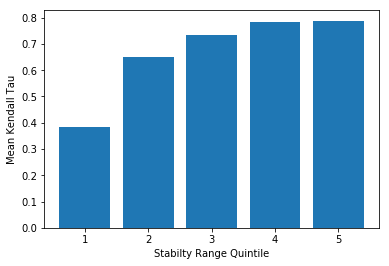

In [7]:
fig, ax = plt.subplots()

n_bins = 5
ranges = np.percentile(scores['range_stability'], np.linspace(0, 100, n_bins+1))
averages = [scores.query('range_stability >= %f and range_stability <= %f'%(ranges[i], ranges[i+1]))['tau'].mean()
            for i in range(n_bins)]

ax.bar(range(n_bins), averages)

ax.set_xticks(range(n_bins))
ax.set_xticklabels('%d'%(i+1) for i in range(n_bins))

ax.set_ylabel('Mean Kendall Tau')
ax.set_xlabel('Stabilty Range Quintile')

pd.DataFrame({'quintile':range(n_bins), 'tau':averages})

*Finding*: The ranking performance is worse for compositions with smaller differences between the energies of each polymorph.

#### How is the ranking pefromance on the more-stable QHs?

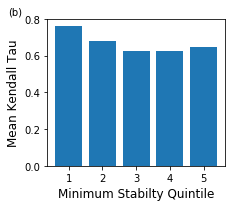

In [8]:
fig, ax = plt.subplots()

n_bins = 5
ranges = np.percentile(scores['min_stability'], np.linspace(0, 100, n_bins+1))
averages = [scores.query('min_stability >= %f and min_stability <= %f'%(ranges[i], ranges[i+1]))['tau'].mean()
            for i in range(n_bins)]

ax.bar(range(n_bins), averages)

ax.set_xticks(range(n_bins))
ax.set_xticklabels('%d'%(i+1) for i in range(n_bins))

ax.set_ylabel('Mean Kendall Tau', fontsize=fontsize)
ax.set_xlabel('Minimum Stabilty Quintile', fontsize=fontsize)

fig.text(0.05,0.95,'(b)')

pd.DataFrame({'quintile':range(n_bins), 'tau':averages})

fig.set_size_inches(fig_width, fig_height)
fig.tight_layout()
fig.savefig('tau_by_stability.png', dpi=320)
fig.savefig('tau_by_stability.pdf')

*Finding*: The ranking performance is not very different for compositions that have more stable polymorphs and those with less table polymorphs. In fact, the ranking performance is strongest for the 1st quintile (i.e., the 20% of compounds with the polymorph that are the most stable).

## Measure Performance on Whole Dataset
Get summary statistics of the performance of the model across the entire test set. We might as well use this opporunity to measure cross-validation scores.

In [9]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(data['class'], data['predicted_class'])
    print(scorer, score)

r2_score 0.913784207011
mean_absolute_error 0.0532509692277
mean_squared_error 0.0055599048129


Get some statistics of the measured class to give this context

In [10]:
print('Dataset Mean Absolute Deviation:', np.mean(np.abs(data['class'] - data['class'].mean())))
print('Dataset Standard Deviation:', np.std(data['class']))

Dataset Mean Absolute Deviation: 0.194415245436
Dataset Standard Deviation: 0.253945349886


Make a CV parity plot

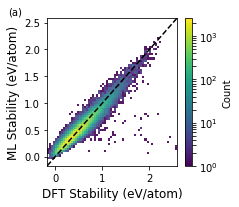

In [11]:
fig, ax = plt.subplots()

min_value = min(data['predicted_class'].min(), data['class'].min())
max_value = max(data['predicted_class'].max(), data['class'].max())

h = ax.hist2d(data['class'], data['predicted_class'], range=[[min_value, max_value],]*2,
              norm=LogNorm(), bins=64, cmap='viridis', alpha=0.9)

ax.set_xlim([min_value, max_value])
ax.set_ylim([min_value, max_value])

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
fig.colorbar(h[-1], label='Count')

ax.set_xlabel('DFT Stability (eV/atom)', fontsize=fontsize)
ax.set_ylabel('ML Stability (eV/atom)', fontsize=fontsize)

fig.text(0.05,0.95,'(a)')

fig.set_size_inches(fig_width, fig_height)
fig.tight_layout()
fig.savefig('parity_plot.png', dpi=320)
fig.savefig('parity_plot.pdf')